In [3]:
import pandas as pd

# Загрузка датасета
df = pd.read_csv('films00_25.csv', sep=';', engine='python')

# Копия для предобработки
df_clean = df.copy()

df_clean = df_clean[df_clean['fees_russia'].notna()]

# Преобразование 'rating_kp' в числовой тип
df_clean['rating_kp'] = pd.to_numeric(df_clean['rating_kp'].astype(str).str.replace(',', '.'), errors='coerce')

# Очистка и преобразование денежной информации в числовой формат
for col in ['budget', 'fees_world', 'fees_usa']:
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.replace(r'[^\d.]', '', regex=True)
        .replace('', '0')
        .astype(float)
    )

df_clean.head()

# Заполнение пропусков в числовых столбцах медианой
num_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns

num_cols

df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

col = 'fees_russia'
df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.replace(r'[^\d.]', '', regex=True)
        .replace('', '0')
        .astype(float)
    )

df_clean

# Удаление столбцов с более чем 70% пропусков
threshold = 0.7
df_clean = df_clean[df_clean.columns[df_clean.isnull().mean() < threshold]]

df_clean['type'].value_counts()

# One-hot кодирование категориальных признаков
df_clean = pd.get_dummies(df_clean, columns=['type'], drop_first=True)
df_clean.columns

df_clean.describe()

df_clean

# Feature engineering: число актеров
df_clean['num_actors'] = df_clean['actor'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

# Кол-во стран
df_clean['num_countries'] = df_clean['countries'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

# Кол-во жанров
df_clean['num_genres'] = df_clean['genres'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

df_clean['is_sequel'] = df_clean['sequelsAndPrequels'].apply(lambda x: 1 if x > 0 else 0)
df_clean['is_adult'] = df_clean['ageRating'].apply(lambda x: 1 if x >= 18 else 0)

person_cols = ['actor', 'designer', 'writer', 'producer', 'operator', 'director', 'composer', 'editor']
for col in person_cols:
    df_clean[col] = df_clean[col].fillna('').apply(lambda x: x.split(',')[0].strip() if x else 'Unknown')

df_clean

from category_encoders import CountEncoder

freq_enc = CountEncoder(cols=person_cols)
df_clean = freq_enc.fit_transform(df_clean)

df_clean

# Удаление текстовых и неинформативных полей
drop_cols = ['name',  'premiere_russia']
df_clean = df_clean.drop(columns=[col for col in drop_cols if col in df_clean.columns])

df_clean = df_clean.drop(columns=['genres', 'fees_world', 'fees_usa'])

df_clean = df_clean.drop(columns=['countries'])

from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=['fees_russia'])
y = df_clean['fees_russia']

df_clean.info()

X.columns

from sklearn.preprocessing import StandardScaler

# Масштабирование
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

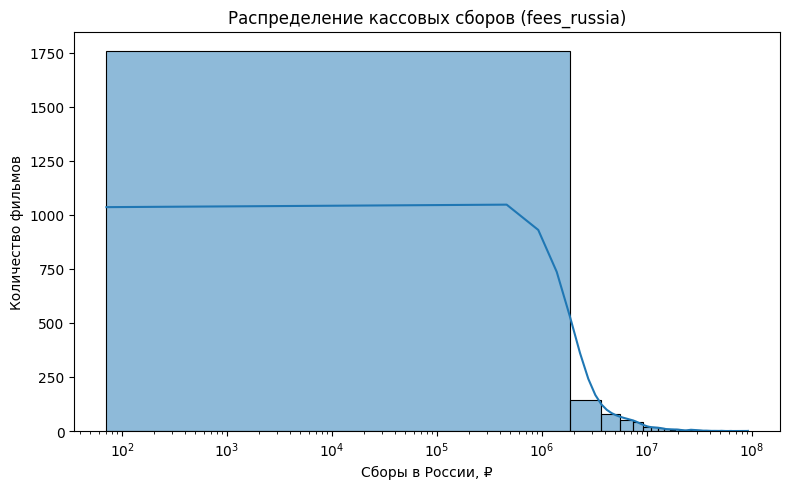

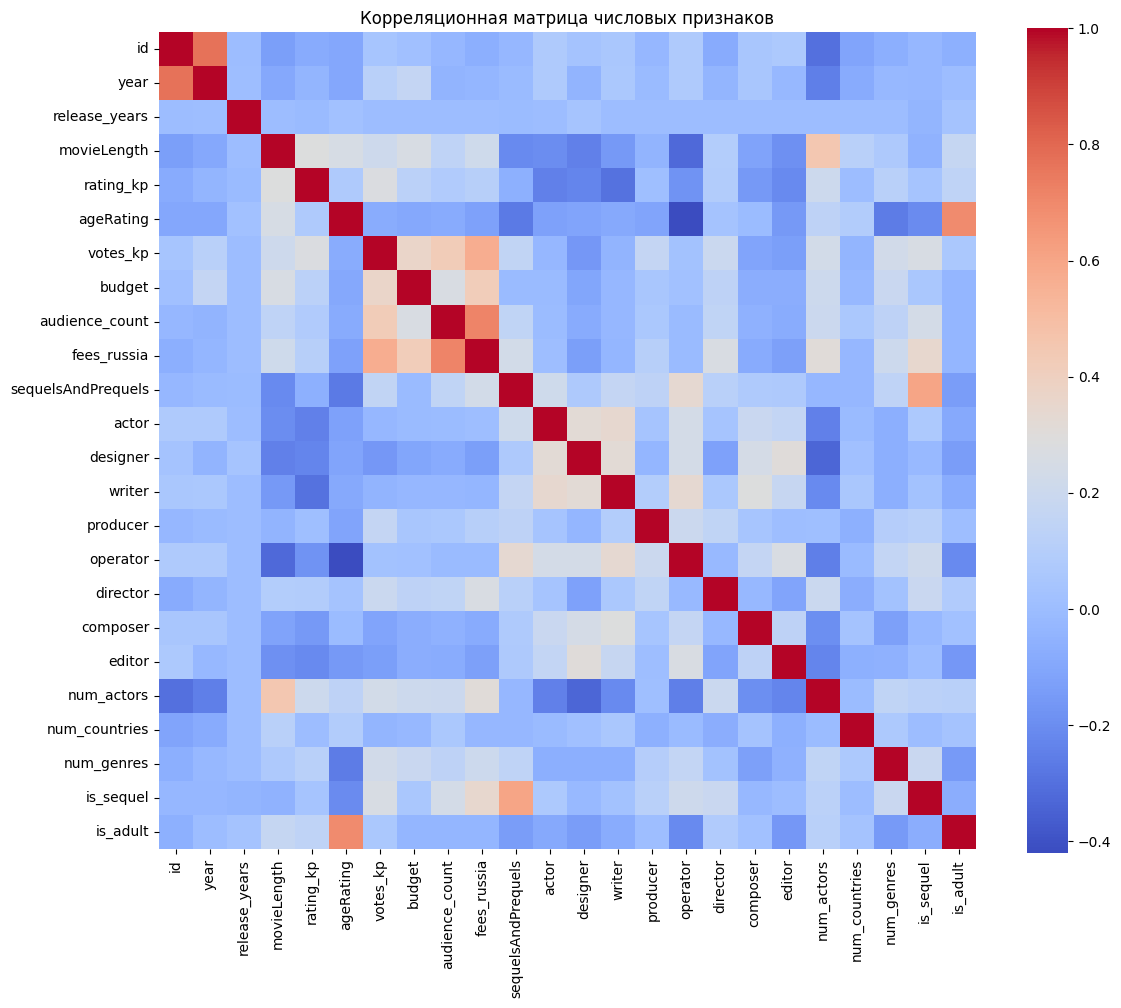

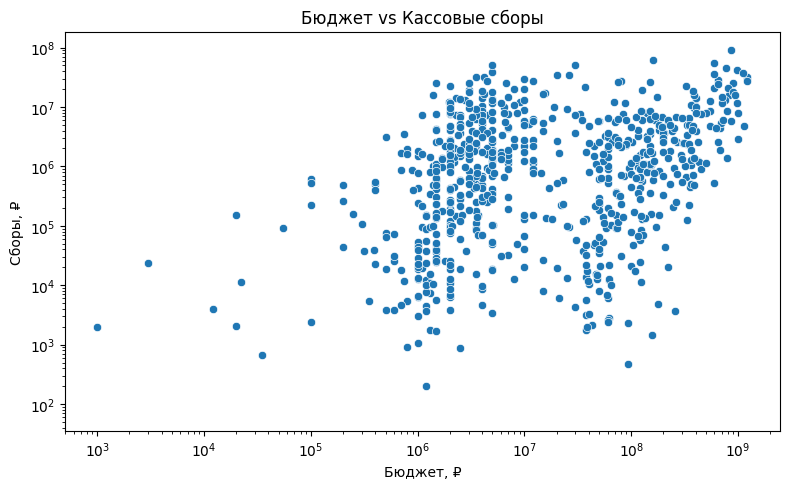

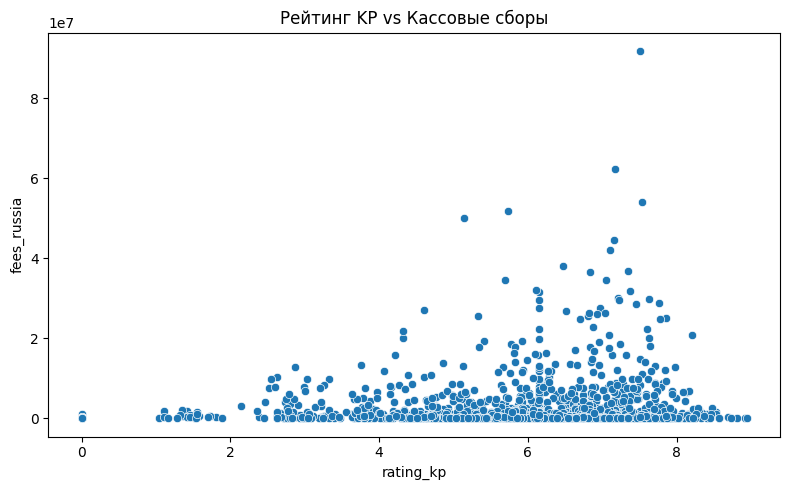

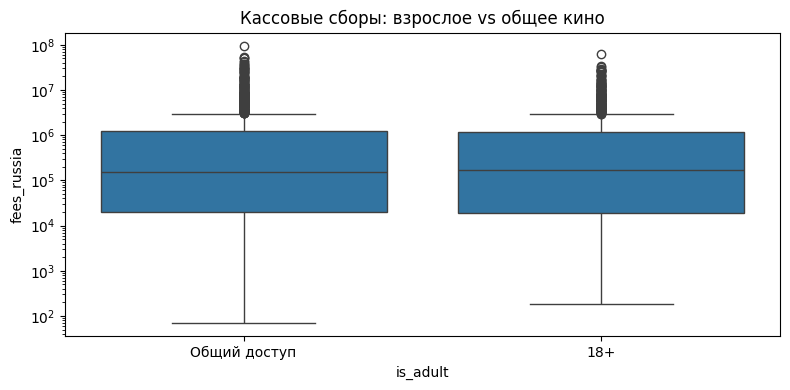

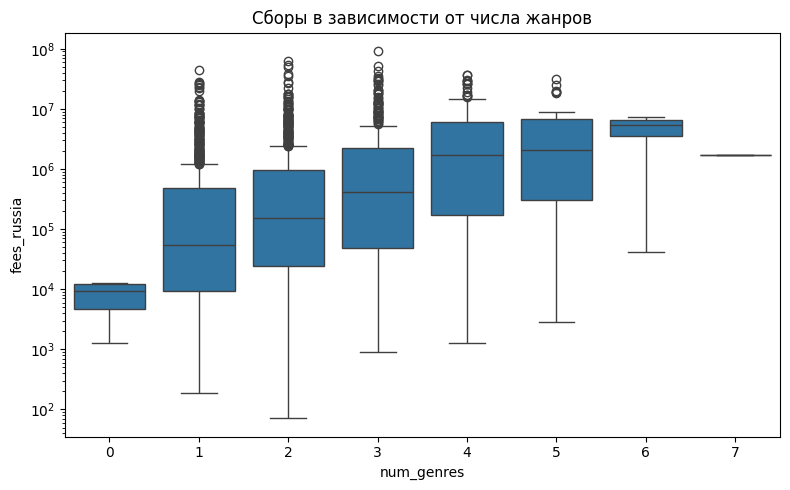

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Убедимся, что используем чистый датафрейм
data = df_clean.copy()

# 1. Распределение целевой переменной
plt.figure(figsize=(8, 5))
sns.histplot(data['fees_russia'], bins=50, kde=True)
plt.title("Распределение кассовых сборов (fees_russia)")
plt.xlabel("Сборы в России, ₽")
plt.ylabel("Количество фильмов")
plt.xscale('log')  # чтобы лучше видеть правый хвост
plt.tight_layout()
plt.show()

# 2. Корреляционная матрица
plt.figure(figsize=(12, 10))
corr = data.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Корреляционная матрица числовых признаков")
plt.tight_layout()
plt.show()

# 3. Влияние бюджета на сборы
plt.figure(figsize=(8, 5))
sns.scatterplot(x='budget', y='fees_russia', data=data)
plt.title("Бюджет vs Кассовые сборы")
plt.xlabel("Бюджет, ₽")
plt.ylabel("Сборы, ₽")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

# 4. Влияние рейтинга
plt.figure(figsize=(8, 5))
sns.scatterplot(x='rating_kp', y='fees_russia', data=data)
plt.title("Рейтинг KP vs Кассовые сборы")
plt.tight_layout()
plt.show()

# 5. Средние сборы по возрастным рейтингам
plt.figure(figsize=(8, 4))
sns.boxplot(x='is_adult', y='fees_russia', data=data)
plt.title("Кассовые сборы: взрослое vs общее кино")
plt.xticks([0, 1], ['Общий доступ', '18+'])
plt.yscale('log')
plt.tight_layout()
plt.show()

# 6. Количество жанров и сборы
plt.figure(figsize=(8, 5))
sns.boxplot(x='num_genres', y='fees_russia', data=data)
plt.title("Сборы в зависимости от числа жанров")
plt.yscale('log')
plt.tight_layout()
plt.show()

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1529, 25), (656, 25), (1529,), (656,))

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

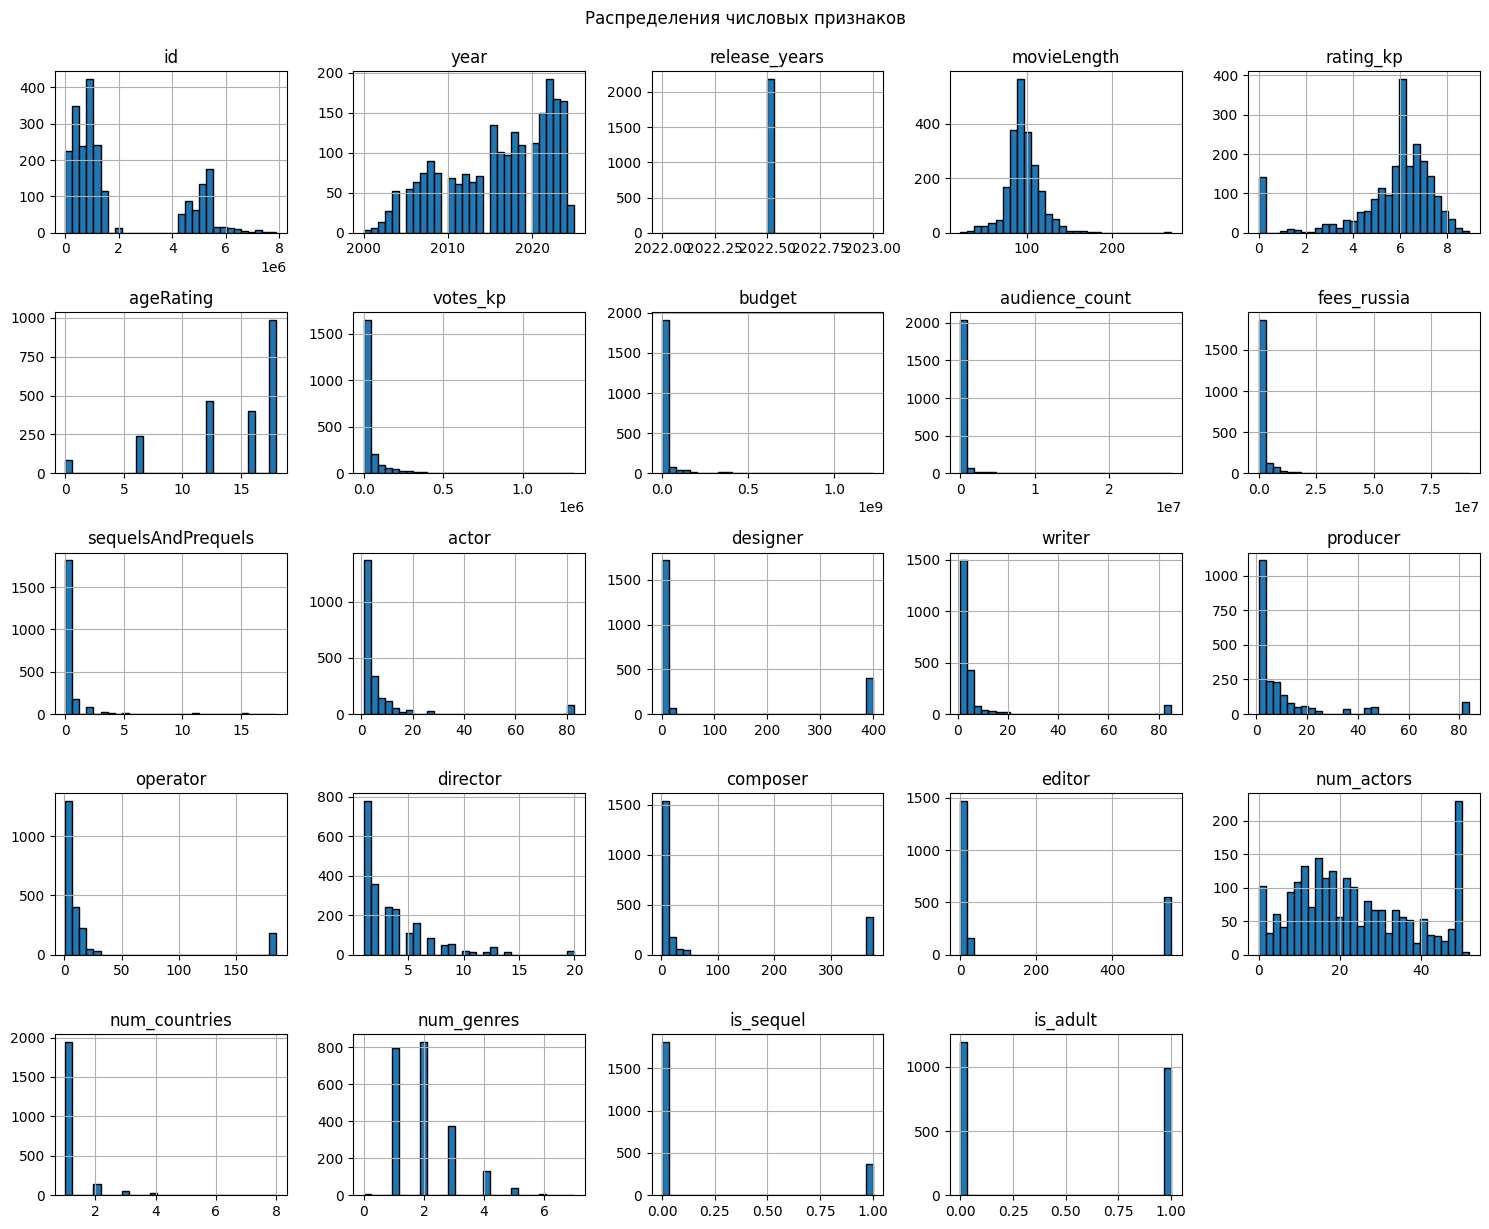

In [50]:
# Гистограммы числовых признаков
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

df_clean[numeric_cols].hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02)
plt.show()

In [88]:
df_clean.to_csv('data.csv')

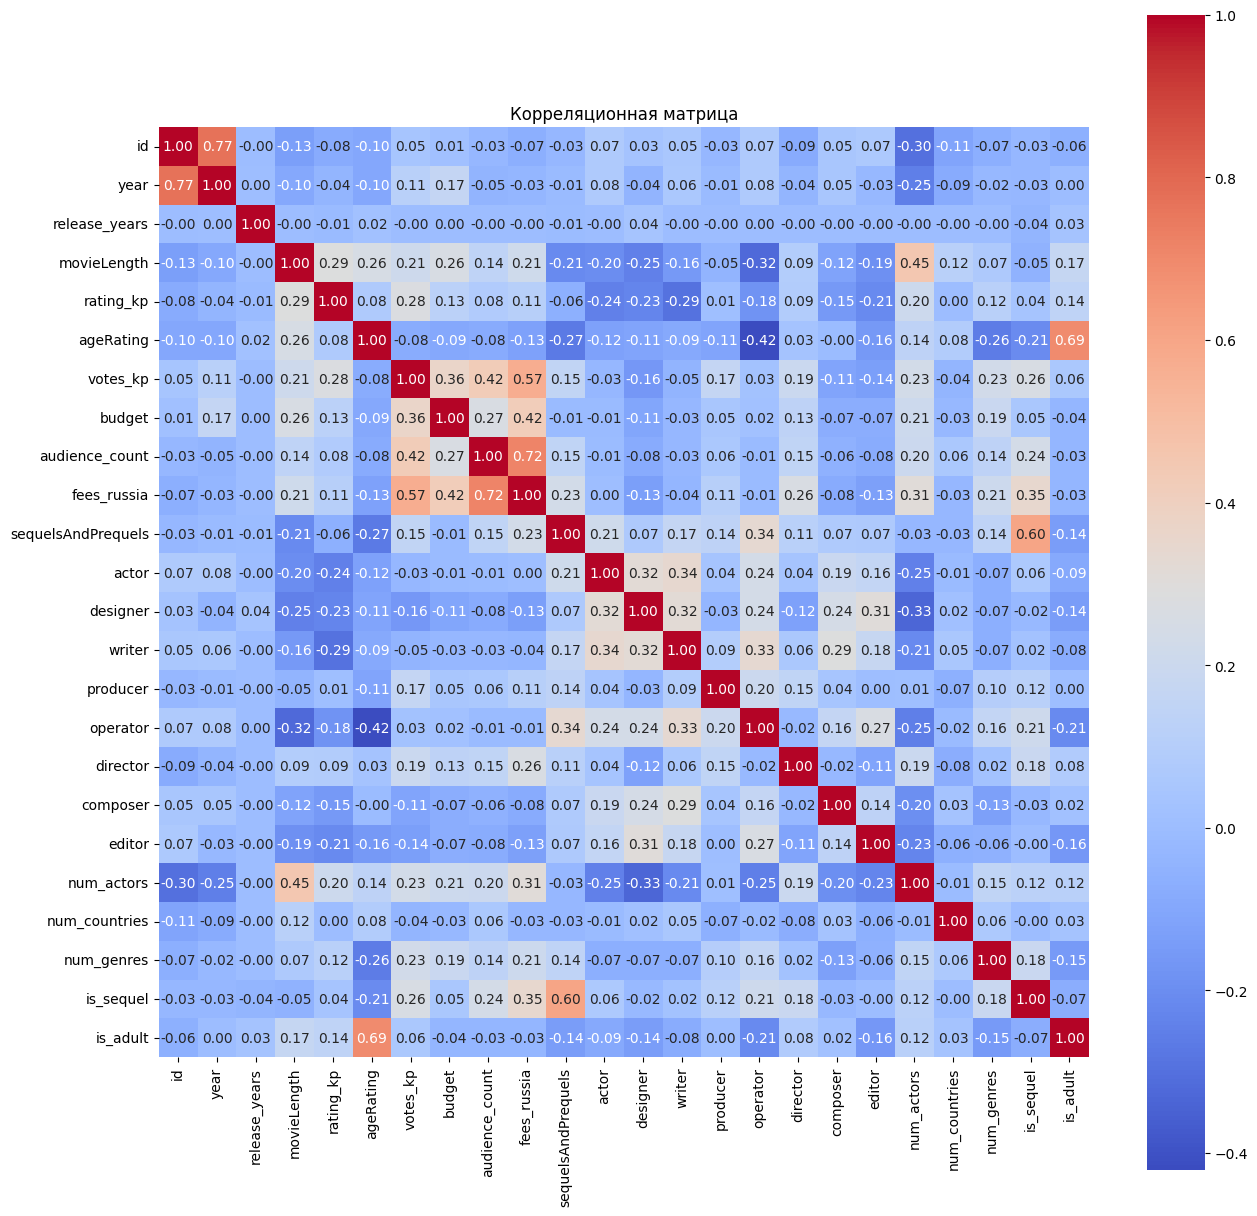

In [51]:
plt.figure(figsize=(15, 15))
corr = df_clean[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Корреляционная матрица")
plt.show()

In [52]:
X_train

,id,year,release_years,movieLength,rating_kp,ageRating,votes_kp,budget,audience_count,sequelsAndPrequels,...,operator,director,composer,editor,type_movie,num_actors,num_countries,num_genres,is_sequel,is_adult
2373,1345717,2020,2022.5,110.0,4.599,18.0,419563,0.0,2250034.0,1,...,12,7,2,2,True,14,1,1,1,1
7466,974203,2016,2022.5,85.0,4.396,18.0,12216,0.0,27230.0,1,...,1,1,4,1,True,15,1,2,1,1
3082,5377804,2024,2022.5,100.0,7.623,18.0,349237,390000000.0,576211.0,0,...,3,3,2,9,True,36,1,2,0,1
2241,1330041,2021,2022.5,78.0,6.152,18.0,87396,0.0,64938.0,0,...,1,4,10,7,True,16,1,2,0,1
2204,1445167,2022,2022.5,76.0,7.377,18.0,53343,120000000.0,334566.0,1,...,7,6,7,10,True,13,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16246,1176159,2018,2022.5,104.0,6.811,18.0,11333,0.0,25610.0,0,...,2,4,374,10,True,23,3,1,0,1
7685,669275,2012,2022.5,89.0,6.584,18.0,61937,0.0,24406.0,0,...,14,8,3,12,True,50,1,2,0,1
7720,464942,2011,2022.5,105.0,6.853,18.0,84299,2200000.0,167018.0,0,...,1,3,18,1,True,50,1,4,0,1
10788,843798,2015,2022.5,94.0,6.201,16.0,5637,10000000.0,23287.0,0,...,2,1,1,1,True,9,1,2,0,0


In [53]:
y_train

2373     10387841.0
7466       649593.0
3082      9755128.0
2241       239382.0
2204      1581060.0
            ...    
16246      115090.0
7685       226114.0
7720      1172420.0
10788       67570.0
7304         2923.0
Name: fees_russia, Length: 1529, dtype: float64

In [57]:
from autogluon.tabular import TabularPredictor
import pandas as pd

# Соберем в одну таблицу (если у тебя уже есть X_train и y_train)
train_data = X_train.copy()
train_data['target'] = y_train

test_data = X_test.copy()
test_data['target'] = y_test  # АвтоГлюон требует наличие цели

# Путь к временной папке (можно изменить)
save_path = 'autogluon_models/'

# Инициализация и обучение
predictor = TabularPredictor(
    label='target',
    path=save_path,
    problem_type='regression',
    eval_metric='mape'
).fit(
    train_data=train_data,
    time_limit=600,  # время обучения (в секундах), можно увеличить
    presets='good'  # или 'medium_quality_faster_train'
)

# Предсказания
preds = predictor.predict(test_data.drop(columns=['target']))

# Оценка
performance = predictor.evaluate(test_data, silent=True)
print("\nPerformance on test data:", performance)

Preset alias specified: 'good' maps to 'good_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.0.0: Mon Aug 12 20:51:54 PDT 2024; root:xnu-11215.1.10~2/RELEASE_ARM64_T6000
CPU Count:          10
Memory Avail:       15.83 GB / 32.00 GB (49.5%)
Disk Space Avail:   276.19 GB / 926.35 GB (29.8%)
Presets specified: ['good']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True

(_ray_fit pid=18741) [1000]	valid_set's l2: 2.29776e+13	valid_set's mean_absolute_percentage_error: -8.84501


(_dystack pid=18605) 	-7.3745	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=18605) 	3.36s	 = Training   runtime
(_dystack pid=18605) 	0.17s	 = Validation runtime
(_dystack pid=18605) Fitting model: WeightedEnsemble_L2 ... Training model for up to 148.20s of the 93.35s of remaining time.
(_dystack pid=18605) 	Ensemble Weights: {'NeuralNetTorch_BAG_L1': 1.0}
(_dystack pid=18605) 	-2.8446	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=18605) 	0.02s	 = Training   runtime
(_dystack pid=18605) 	0.0s	 = Validation runtime
(_dystack pid=18605) Fitting 9 L2 models, fit_strategy="sequential" ...
(_dystack pid=18605) Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 93.33s of the 93.33s of remaining time.
(_dystack pid=18605) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.07%)
(pid=18740) /Users/mariakofanova/anaconda3/lib/python3.11/site-packages/pandas/core

(_ray_fit pid=18869) [1000]	valid_set's l2: 3.62867e+12	valid_set's mean_absolute_percentage_error: -5.80248 [repeated 2x across cluster]
(_ray_fit pid=18869) [4000]	valid_set's l2: 3.62819e+12	valid_set's mean_absolute_percentage_error: -5.80194 [repeated 6x across cluster]


(_dystack pid=18605) 	-6.5333	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=18605) 	11.85s	 = Training   runtime
(_dystack pid=18605) 	0.49s	 = Validation runtime
(_dystack pid=18605) Fitting model: WeightedEnsemble_L3 ... Training model for up to 148.20s of the 13.12s of remaining time.
(_dystack pid=18605) 	Ensemble Weights: {'NeuralNetTorch_BAG_L2': 1.0}
(_dystack pid=18605) 	-2.0447	 = Validation score   (-mean_absolute_percentage_error)
(_dystack pid=18605) 	0.04s	 = Training   runtime
(_dystack pid=18605) 	0.0s	 = Validation runtime
(_dystack pid=18605) AutoGluon training complete, total runtime = 135.15s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 454.9 rows/s (170 batch size)
(_dystack pid=18605) Automatically performing refit_full as a post-fit operation (due to `.fit(..., refit_full=True)`
(_dystack pid=18605) Refitting models via `predictor.refit_full` using all of the data (combined train and validation)...
(_dystack pid=186


Performance on test data: {'mean_absolute_percentage_error': -1.3571291685760503, 'root_mean_squared_error': -5562767.910268135, 'mean_squared_error': -30944386823508.92, 'mean_absolute_error': -1832332.2004089123, 'r2': -0.06974953589400035, 'pearsonr': 0.41101157913615477, 'median_absolute_error': -141595.26293945312}


In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Инициализация модели
rf_model = RandomForestRegressor(
    n_estimators=1000,      # количество деревьев
    max_depth=45,        # глубина дерева (можно ограничить)
    random_state=42,       # для воспроизводимости
    n_jobs=-1              # использование всех ядер
)

# Обучение модели
rf_model.fit(X_train, y_train)

# Предсказание
y_pred = rf_model.predict(X_test)

# Оценка качества
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {rmse:.4f}")
print(f"R² score: {r2:.4f}")

MSE: 5997786634142.4072
R² score: 0.7927


In [66]:
mean_absolute_percentage_error(y_test, y_pred)

7.178841536475305

In [68]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Модель с пнями (max_depth=1) — приближение линейного бустинга
gbr = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=10,           # очень простые деревья
    random_state=42,
    verbose=1
)

# Обучение
gbr.fit(X_train, y_train)

# Предсказание
y_pred = gbr.predict(X_test)

# Оценка
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Gradient Boosting (stumps):")
print(f"MSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

      Iter       Train Loss   Remaining Time 
         1 23900862373035.1172            5.20s
         2 19395055364057.1133            4.87s
         3 15742036868468.4160            4.71s
         4 12778504854808.1250            4.80s
         5 10375028634056.1016            4.63s
         6 8447955308927.9922            4.50s
         7 6881065349862.7598            4.38s
         8 5607573480473.4961            4.30s
         9 4557497974370.8818            4.22s
        10 3719363480139.3589            4.15s
        20 492223955625.3622            3.77s
        30 75219212372.6426            3.59s
        40 15895004895.8463            3.45s
        50  5755142057.0146            3.32s
        60  2819168800.2094            3.21s
        70  1654590433.3565            3.09s
        80   943739198.2198            2.99s
        90   501250708.0647            2.89s
       100   249665316.8644            2.79s
       200      404954.6857            1.86s
       300        1641.5544 

In [69]:
mean_absolute_percentage_error(y_test, y_pred)

8.62078654776956

In [71]:
import lightgbm as lgb

params = {
    'objective': 'regression',
    'learning_rate': 0.01,
    'n_estimators': 5000,
    'verbose':1
}

lgb_model = lgb.LGBMRegressor(**params)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
    eval_metric='rmse')

y_pred = lgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"LightGBM Boosting (linear-style):")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1487
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 23
[LightGBM] [Info] Start training from score 1906964.671027
LightGBM Boosting (linear-style):
RMSE: 5676076214915.8418
R²: 0.8038


In [72]:
mean_absolute_percentage_error(y_test, y_pred)

13.584852420514308

In [76]:
mean_absolute_percentage_error(y_test, y_pred)

0.940090483627821

In [89]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    ExtraTreesRegressor, BaggingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{name}:\n  RMSE = {rmse:.4f}, R² = {r2:.4f}\n mape = {mape:.4f}")

evaluate_model("Linear Regression", LinearRegression())
evaluate_model("Ridge Regression", Ridge(alpha=1.0))
evaluate_model("Lasso Regression", Lasso(alpha=0.1))
evaluate_model("Decision Tree", DecisionTreeRegressor(random_state=42, max_depth=5))
evaluate_model("AdaBoost", AdaBoostRegressor(n_estimators=100, random_state=42))
evaluate_model("Extra Trees", ExtraTreesRegressor(n_estimators=100, random_state=42))
evaluate_model("Bagging Regressor", BaggingRegressor(n_estimators=100, random_state=42))
evaluate_model("SVR", SVR(kernel='rbf', C=1.0))

Linear Regression:
  RMSE = 8647968965817.5029, R² = 0.7010
 mape = 63.2060
Ridge Regression:
  RMSE = 8650713608025.1602, R² = 0.7009
 mape = 63.3713


/Users/mariakofanova/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.26951e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Lasso Regression:
  RMSE = 8647969317410.1855, R² = 0.7010
 mape = 63.2061
Decision Tree:
  RMSE = 10861273571148.1562, R² = 0.6245
 mape = 33.5984
AdaBoost:
  RMSE = 18544009287882.2148, R² = 0.3589
 mape = 421.3549
Extra Trees:
  RMSE = 5684896586979.1445, R² = 0.8035
 mape = 6.5880
Bagging Regressor:
  RMSE = 6034132148226.5439, R² = 0.7914
 mape = 7.1613
SVR:
  RMSE = 32042945907334.4219, R² = -0.1077
 mape = 16.9482


In [73]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

params = {
    'loss_function': 'MAPE',
    'learning_rate': 0.001,
    'iterations': 5000,
    'depth':3,
    'verbose': 100
}

cat_model = CatBoostRegressor(**params)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

y_pred = cat_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("CatBoost Regressor:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

0:	learn: 0.9499539	test: 0.9623249	best: 0.9623249 (0)	total: 637us	remaining: 3.19s
100:	learn: 0.9484054	test: 0.9613113	best: 0.9613113 (100)	total: 41.6ms	remaining: 2.02s
200:	learn: 0.9469599	test: 0.9602419	best: 0.9602419 (200)	total: 78.1ms	remaining: 1.86s
300:	learn: 0.9455416	test: 0.9594344	best: 0.9594344 (300)	total: 113ms	remaining: 1.76s
400:	learn: 0.9442033	test: 0.9587246	best: 0.9586703 (385)	total: 148ms	remaining: 1.7s
500:	learn: 0.9430339	test: 0.9579387	best: 0.9579387 (500)	total: 183ms	remaining: 1.64s
600:	learn: 0.9418451	test: 0.9569556	best: 0.9569556 (600)	total: 219ms	remaining: 1.6s
700:	learn: 0.9408058	test: 0.9561130	best: 0.9561130 (700)	total: 254ms	remaining: 1.56s
800:	learn: 0.9397452	test: 0.9553218	best: 0.9553218 (800)	total: 288ms	remaining: 1.51s
900:	learn: 0.9387521	test: 0.9546370	best: 0.9546370 (900)	total: 323ms	remaining: 1.47s
1000:	learn: 0.9377953	test: 0.9534832	best: 0.9534832 (1000)	total: 357ms	remaining: 1.43s
1100:	learn:

In [74]:
mean_absolute_percentage_error(y_test, y_pred)

0.940733427194876

In [75]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

params = {
    'loss_function': 'MAPE',
    'learning_rate': 0.0001,
    'iterations': 50000,
    'depth':3,
    'verbose': 100
}

cat_model = CatBoostRegressor(**params)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

y_pred = cat_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("CatBoost Regressor:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

0:	learn: 0.9499724	test: 0.9623372	best: 0.9623372 (0)	total: 918us	remaining: 45.9s
100:	learn: 0.9498150	test: 0.9622388	best: 0.9622388 (100)	total: 40.8ms	remaining: 20.1s
200:	learn: 0.9496620	test: 0.9621270	best: 0.9621270 (200)	total: 78.9ms	remaining: 19.5s
300:	learn: 0.9495019	test: 0.9620373	best: 0.9620373 (300)	total: 113ms	remaining: 18.7s
400:	learn: 0.9493451	test: 0.9619560	best: 0.9619509 (385)	total: 148ms	remaining: 18.3s
500:	learn: 0.9492043	test: 0.9618610	best: 0.9618610 (500)	total: 182ms	remaining: 18s
600:	learn: 0.9490563	test: 0.9617511	best: 0.9617511 (600)	total: 219ms	remaining: 18s
700:	learn: 0.9489097	test: 0.9616375	best: 0.9616375 (700)	total: 252ms	remaining: 17.8s
800:	learn: 0.9487616	test: 0.9615340	best: 0.9615340 (800)	total: 287ms	remaining: 17.6s
900:	learn: 0.9486091	test: 0.9614231	best: 0.9614231 (900)	total: 319ms	remaining: 17.4s
1000:	learn: 0.9484662	test: 0.9612487	best: 0.9612487 (1000)	total: 356ms	remaining: 17.4s
1100:	learn: 0